In [27]:
!pip install albumentations
!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

^C


In [ ]:
!pip install segmentation-models-pytorch
!pip install torchsummary


In [ ]:
!pip install huggingface-hub==0.16.4


   ---------------------------------------- 0.0/268.8 kB ? eta -:--:--
   - -------------------------------------- 10.2/268.8 kB ? eta -:--:--
   ---------- ---------------------------- 71.7/268.8 kB 975.2 kB/s eta 0:00:01
   ------------------------- -------------- 174.1/268.8 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 268.8/268.8 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.24.6
    Uninstalling huggingface-hub-0.24.6:
      Successfully uninstalled huggingface-hub-0.24.6


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.21.0 requires huggingface-hub>=0.21.2, but you have huggingface-hub 0.16.4 which is incompatible.
segmentation-models-pytorch 0.3.4 requires huggingface-hub>=0.24.6, but you have huggingface-hub 0.16.4 which is incompatible.
transformers 4.44.2 requires huggingface-hub<1.0,>=0.23.2, but you have huggingface-hub 0.16.4 which is incompatible.


In [ ]:
import segmentation_models_pytorch as smp
from torchsummary import summary


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

#!pip install -q segmentation-models-pytorch
#!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

#print(os.getenv('PATH'))
print(torch.cuda.is_available())

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

True


device(type='cuda')

In [ ]:
from pathlib import Path

# For local file paths (Windows)
data_directory = Path(r'D:\ML_Seagrass\SourceData\Alaska\Alaska\train')

IMAGE_PATH = data_directory / "image"
MASK_PATH = data_directory / "index"

print("image_path:", IMAGE_PATH)



image_path: D:\ML_Seagrass\SourceData\Alaska\Alaska\train\image


In [ ]:
try:
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision not available.")

torch version: 2.1.1+cu118
torchvision version: 0.16.1+cu118


In [ ]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.current_device())  # Should return the current GPU device
print(torch.cuda.get_device_name(0))  # Should return the name of the GPU


True
0
NVIDIA GeForce RTX 3060


In [ ]:
n_classes = 2 # classes of the mask

def create_dataframe():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id':name}, index= np.arange(0, len(name)))

df = create_dataframe()

df

,id
0,FI_AK_19_row10_col1
1,FI_AK_19_row10_col18
2,FI_AK_19_row10_col19
3,FI_AK_19_row10_col3
4,FI_AK_19_row11_col16
...,...
835,SH_AK_22_row7_col10
836,SH_AK_22_row7_col11
837,SH_AK_22_row7_col12
838,SH_AK_22_row8_col10


In [ ]:
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

Image Path: D:\ML_Seagrass\SourceData\Alaska\Alaska\train\image\NO_AK_22_row3_col10.png
Mask Path: D:\ML_Seagrass\SourceData\Alaska\Alaska\train\index\NO_AK_22_row3_col10.png


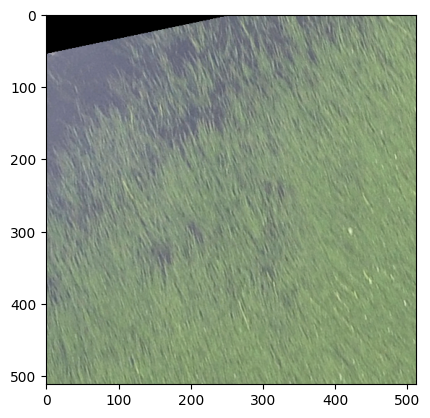

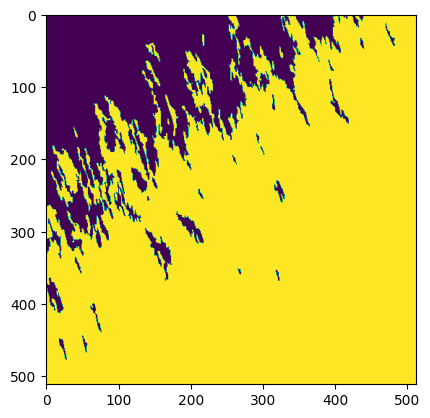

(512, 512, 3)
(512, 512)


In [ ]:
for idx in X_val:
    img_path = os.path.join(IMAGE_PATH, idx + '.png')
    mask_path = os.path.join(MASK_PATH, idx + '.png')

    
    # Print out the file paths for debugging
    print("Image Path:", img_path)
    print("Mask Path:", mask_path)
    
    img = Image.open(img_path)
    mask = Image.open(mask_path)
    plt.imshow(img)
    plt.show()
    plt.imshow(mask)
    plt.show()
    print(np.asarray(img).shape)
    print(np.asarray(mask).shape)
    break

In [ ]:
class Drone_data(Dataset):
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = Path(img_path)
        self.mask_path = Path(mask_path)
        self.X = X
        self.mean = mean
        self.std = std
        self.transform = transform
        self.patch = patch

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Create image and mask paths using pathlib
        img_path = self.img_path / f'{self.X[idx]}.png'
        mask_path = self.mask_path / f'{self.X[idx]}.png'
        
        # Read and convert the image to RGB
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Open and convert the mask to grayscale
        mask = Image.open(mask_path)
        mask = mask.convert("L")
        mask = np.array(mask)

        # Map mask values: 255 -> 1
        mask = np.where(mask == 255, 1, 0).astype(np.uint8)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = aug['image']
            mask = aug['mask']

        # Convert image to tensor and normalize
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        
        # Convert mask to a tensor
        mask = torch.from_numpy(mask).long()

        if self.patch:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask):
        # Implementation of tile extraction if needed
        pass

In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(),
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = Drone_data(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = Drone_data(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 4

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [ ]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=2, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

In [ ]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [ ]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            #output = torch.argmax(output, dim=1)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight
            optimizer.zero_grad() #reset gradient

            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))


            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    
    total_time_minutes = (time.time() - fit_time) / 60

    # Print the total time
    print('Total time: {:.2f} m'.format(total_time_minutes))

    #print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import subprocess

def check_gpu_memory():
    result = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE)
    print(result.stdout.decode('utf-8'))

check_gpu_memory()

Wed Aug 28 16:04:54 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.12                 Driver Version: 556.12         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
| 37%   45C    P8             10W /  170W |     549MiB /  12288MiB |     17%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
import torch

# Enable CUDA_LAUNCH_BLOCKING
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Your previous setup code
max_lr = 1e-4
epoch = 20
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

# Ensure model is on the correct device
model.to(device)

# Run fit function
history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.624 
Epoch:1/20.. Train Loss: 0.755.. Val Loss: 0.624.. Train mIoU:0.376.. Val mIoU: 0.465.. Train Acc:0.551.. Val Acc:0.644.. Time: 3.09m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Decreasing.. 0.624 >> 0.517 
Epoch:2/20.. Train Loss: 0.618.. Val Loss: 0.517.. Train mIoU:0.486.. Val mIoU: 0.599.. Train Acc:0.656.. Val Acc:0.761.. Time: 2.21m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Decreasing.. 0.517 >> 0.455 
Epoch:3/20.. Train Loss: 0.567.. Val Loss: 0.455.. Train mIoU:0.536.. Val mIoU: 0.615.. Train Acc:0.698.. Val Acc:0.779.. Time: 2.19m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Decreasing.. 0.455 >> 0.431 
saving model...
Epoch:4/20.. Train Loss: 0.540.. Val Loss: 0.431.. Train mIoU:0.567.. Val mIoU: 0.649.. Train Acc:0.723.. Val Acc:0.795.. Time: 2.19m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:5/20.. Train Loss: 0.529.. Val Loss: 0.442.. Train mIoU:0.582.. Val mIoU: 0.632.. Train Acc:0.733.. Val Acc:0.788.. Time: 2.20m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Decreasing.. 0.442 >> 0.433 
Epoch:6/20.. Train Loss: 0.517.. Val Loss: 0.433.. Train mIoU:0.594.. Val mIoU: 0.613.. Train Acc:0.743.. Val Acc:0.780.. Time: 2.18m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Decreasing.. 0.433 >> 0.429 
Epoch:7/20.. Train Loss: 0.523.. Val Loss: 0.429.. Train mIoU:0.567.. Val mIoU: 0.634.. Train Acc:0.725.. Val Acc:0.785.. Time: 2.19m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:8/20.. Train Loss: 0.514.. Val Loss: 0.437.. Train mIoU:0.585.. Val mIoU: 0.633.. Train Acc:0.738.. Val Acc:0.794.. Time: 2.31m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Decreasing.. 0.437 >> 0.404 
Epoch:9/20.. Train Loss: 0.498.. Val Loss: 0.404.. Train mIoU:0.599.. Val mIoU: 0.658.. Train Acc:0.750.. Val Acc:0.806.. Time: 2.23m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:10/20.. Train Loss: 0.495.. Val Loss: 0.418.. Train mIoU:0.601.. Val mIoU: 0.651.. Train Acc:0.749.. Val Acc:0.803.. Time: 2.16m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Decreasing.. 0.418 >> 0.399 
Epoch:11/20.. Train Loss: 0.479.. Val Loss: 0.399.. Train mIoU:0.616.. Val mIoU: 0.640.. Train Acc:0.764.. Val Acc:0.799.. Time: 2.24m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:12/20.. Train Loss: 0.489.. Val Loss: 0.406.. Train mIoU:0.606.. Val mIoU: 0.653.. Train Acc:0.756.. Val Acc:0.805.. Time: 2.20m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Decreasing.. 0.406 >> 0.399 
saving model...
Epoch:13/20.. Train Loss: 0.468.. Val Loss: 0.399.. Train mIoU:0.620.. Val mIoU: 0.667.. Train Acc:0.767.. Val Acc:0.813.. Time: 2.20m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:14/20.. Train Loss: 0.474.. Val Loss: 0.424.. Train mIoU:0.619.. Val mIoU: 0.650.. Train Acc:0.766.. Val Acc:0.805.. Time: 2.18m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Decreasing.. 0.424 >> 0.389 
Epoch:15/20.. Train Loss: 0.464.. Val Loss: 0.389.. Train mIoU:0.616.. Val mIoU: 0.671.. Train Acc:0.767.. Val Acc:0.816.. Time: 2.22m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:16/20.. Train Loss: 0.452.. Val Loss: 0.408.. Train mIoU:0.626.. Val mIoU: 0.657.. Train Acc:0.774.. Val Acc:0.804.. Time: 2.25m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Decreasing.. 0.408 >> 0.388 
Epoch:17/20.. Train Loss: 0.450.. Val Loss: 0.388.. Train mIoU:0.629.. Val mIoU: 0.668.. Train Acc:0.775.. Val Acc:0.816.. Time: 2.18m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Not Decrease for 7 time
Loss not decrease for 7 times, Stop Training
Total time: 40.65 m


In [ ]:
max_lr = 1e-4
epoch = 20
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.394 
Epoch:1/20.. Train Loss: 0.444.. Val Loss: 0.394.. Train mIoU:0.635.. Val mIoU: 0.673.. Train Acc:0.781.. Val Acc:0.814.. Time: 2.25m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Decreasing.. 0.394 >> 0.379 
Epoch:2/20.. Train Loss: 0.441.. Val Loss: 0.379.. Train mIoU:0.639.. Val mIoU: 0.674.. Train Acc:0.783.. Val Acc:0.821.. Time: 2.21m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:3/20.. Train Loss: 0.465.. Val Loss: 0.402.. Train mIoU:0.627.. Val mIoU: 0.671.. Train Acc:0.775.. Val Acc:0.810.. Time: 2.26m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Decreasing.. 0.402 >> 0.386 
Epoch:4/20.. Train Loss: 0.453.. Val Loss: 0.386.. Train mIoU:0.636.. Val mIoU: 0.678.. Train Acc:0.779.. Val Acc:0.817.. Time: 2.24m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:5/20.. Train Loss: 0.470.. Val Loss: 0.397.. Train mIoU:0.615.. Val mIoU: 0.673.. Train Acc:0.764.. Val Acc:0.817.. Time: 2.24m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Decreasing.. 0.397 >> 0.386 
saving model...
Epoch:6/20.. Train Loss: 0.456.. Val Loss: 0.386.. Train mIoU:0.632.. Val mIoU: 0.676.. Train Acc:0.776.. Val Acc:0.819.. Time: 2.27m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:7/20.. Train Loss: 0.459.. Val Loss: 0.477.. Train mIoU:0.629.. Val mIoU: 0.656.. Train Acc:0.774.. Val Acc:0.806.. Time: 2.26m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Decreasing.. 0.477 >> 0.389 
Epoch:8/20.. Train Loss: 0.457.. Val Loss: 0.389.. Train mIoU:0.633.. Val mIoU: 0.669.. Train Acc:0.779.. Val Acc:0.822.. Time: 2.25m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:9/20.. Train Loss: 0.458.. Val Loss: 0.451.. Train mIoU:0.624.. Val mIoU: 0.642.. Train Acc:0.774.. Val Acc:0.798.. Time: 2.27m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Decreasing.. 0.451 >> 0.400 
Epoch:10/20.. Train Loss: 0.459.. Val Loss: 0.400.. Train mIoU:0.629.. Val mIoU: 0.673.. Train Acc:0.777.. Val Acc:0.817.. Time: 2.24m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Decreasing.. 0.400 >> 0.371 
Epoch:11/20.. Train Loss: 0.454.. Val Loss: 0.371.. Train mIoU:0.635.. Val mIoU: 0.692.. Train Acc:0.779.. Val Acc:0.832.. Time: 2.20m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:12/20.. Train Loss: 0.431.. Val Loss: 0.375.. Train mIoU:0.654.. Val mIoU: 0.707.. Train Acc:0.794.. Val Acc:0.833.. Time: 2.25m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:13/20.. Train Loss: 0.437.. Val Loss: 0.385.. Train mIoU:0.646.. Val mIoU: 0.702.. Train Acc:0.790.. Val Acc:0.831.. Time: 2.22m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Decreasing.. 0.385 >> 0.377 
Epoch:14/20.. Train Loss: 0.430.. Val Loss: 0.377.. Train mIoU:0.647.. Val mIoU: 0.688.. Train Acc:0.789.. Val Acc:0.832.. Time: 2.25m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Not Decrease for 7 time
Loss not decrease for 7 times, Stop Training
Total time: 33.61 m


In [ ]:
torch.save(model, 'Unet-mobilenet2-batchsize4-Alaska_lr-4.pt')

In [ ]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

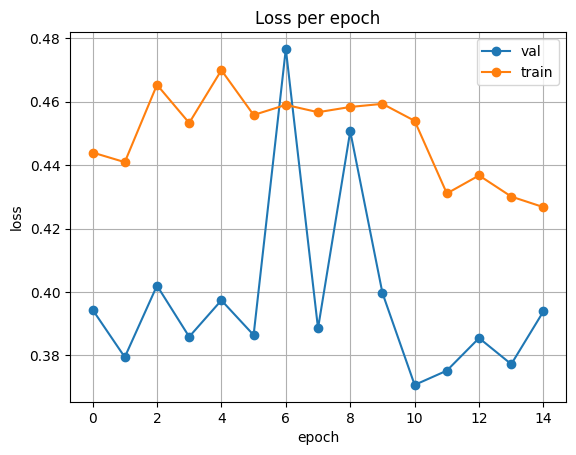

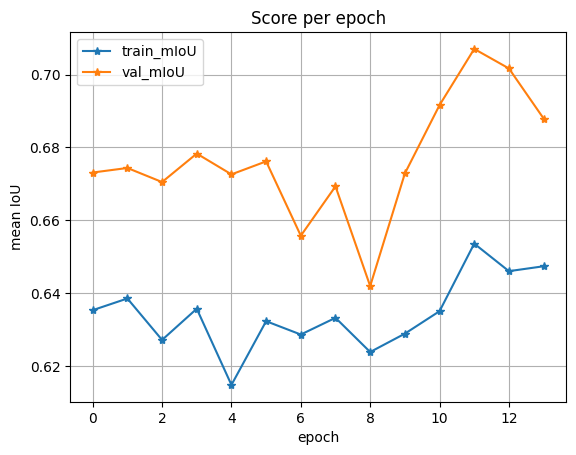

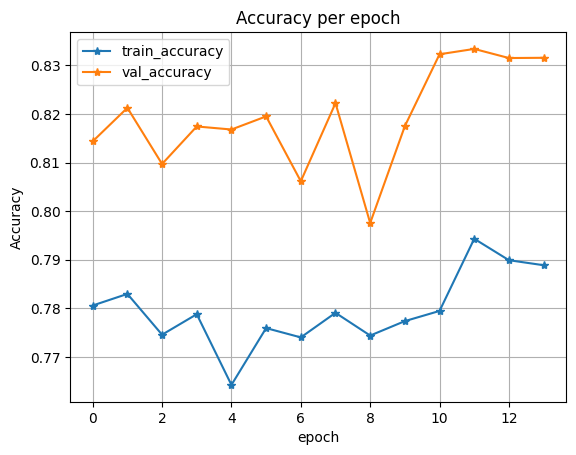

In [ ]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [ ]:
import torchvision.transforms as transforms

def to_tensor(image):
    return transforms.ToTensor()(image)

In [ ]:

# Step 1: Load the entire model
model = torch.load('Unet-mobilenet2-batchsize4-Alaska_lr-4.pt')

# Step 2: Switch the model to evaluation mode
model.eval()

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

In [ ]:
class DroneTestDataset(Dataset):
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = Path(img_path)
        self.mask_path = Path(mask_path)
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Create image and mask paths using pathlib
        img_file_name = f'{self.X[idx]}.png'
        img_path = self.img_path / img_file_name
        mask_path = self.mask_path / img_file_name
        
        # Read and convert the image to RGB using OpenCV
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Read the mask in grayscale directly using OpenCV
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            # Convert image and mask to NumPy arrays for transformation
            transformed = self.transform(image=img, mask=mask)
            img = transformed['image']
            mask = transformed['mask']
        
        # Convert the image to PIL Image (consistent with DroneTestDataset1)
        img = Image.fromarray(img)

        # Convert mask to a PyTorch tensor
        mask = torch.from_numpy(mask).long()

        # Return the image, mask, and file name
        return img, mask, img_file_name

t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [29]:

# Define the directory to save the predicted masks
output_dir = Path(r'D:\ML_Seagrass\SourceData\Alaska\Alaska\predicted')
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

def pad_image(image_tensor, divisor=32):
    # Get the current height and width
    _, _, h, w = image_tensor.shape
    
    # Calculate the padding needed for height and width
    pad_h = (divisor - h % divisor) if h % divisor != 0 else 0
    pad_w = (divisor - w % divisor) if w % divisor != 0 else 0
    
    # Apply padding (pad_left, pad_right, pad_top, pad_bottom)
    padded_image = F.pad(image_tensor, (0, pad_w, 0, pad_h), mode='constant', value=0)
    
    return padded_image

# Iterate over the dataset
for idx in range(len(test_set)):
    # Get the image, mask, and file name from the dataset
    image, mask, file_name = test_set[idx]
    
    # Convert the image to tensor and add batch dimension
    image_tensor = torch.tensor(np.array(image)).unsqueeze(0)
    
    # Apply padding to make the height and width divisible by 32
    image_tensor = pad_image(image_tensor)
    
    # Make sure to disable gradient calculation during inference
    with torch.no_grad():
        # Get the predicted mask from the model
        pred_mask = model(image_tensor)

    # Convert the predicted mask to a numpy array (assumes single-channel output)
    pred_mask = torch.argmax(pred_mask, dim=1).squeeze(0).cpu().numpy()  # Convert to numpy
    
    # Save the predicted mask using the same file name as input
    pred_mask_path = os.path.join(output_dir, file_name)
    
    # Save the mask as PNG (or any other format), ensure to convert to uint8 format if necessary
    cv2.imwrite(pred_mask_path, pred_mask.astype(np.uint8))
    
    print(f'Saved predicted mask for {file_name} to {pred_mask_path}')

RuntimeError: Wrong input shape height=1152, width=3. Expected image height and width divisible by 32. Consider pad your images to shape (1152, 32).

In [ ]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [ ]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [ ]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask, file_name = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [28]:
mob_miou = miou_score(model, test_set)
mob_miou

  0%|          | 0/84 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 2)

In [18]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [ ]:
mob_acc = pixel_acc(model, test_set)
mob_acc

  0%|          | 0/84 [00:00<?, ?it/s]

[0.06111879701967592,
 0.1070556640625,
 0.08848063151041667,
 0.009417498553240741,
 0.6669910572193287,
 0.048773871527777776,
 0.7127719455295138,
 0.33125587745949076,
 0.0,
 0.5000011302806713,
 0.2137168601707176,
 0.002215350115740741,
 0.46163149233217593,
 0.8260633680555556,
 0.8497020580150463,
 0.0004023799189814815,
 0.0038734718605324073,
 0.42273740415219907,
 9.04224537037037e-06,
 0.0,
 0.5715241608796297,
 0.8580039695457176,
 0.021323875144675927,
 0.0,
 0.42438987449363424,
 0.6101560239438657,
 0.018367060908564815,
 0.19697401258680555,
 0.7554389105902778,
 0.33475861725983797,
 0.7392894603587963,
 0.5387369791666666,
 0.01804719147858796,
 0.1632758246527778,
 0.8273032859519676,
 0.5366685655381944,
 1.1302806712962962e-06,
 0.0,
 0.003699408637152778,
 0.0002723976417824074,
 0.7253666630497685,
 0.7643025716145834,
 0.6967016149450231,
 0.2258673773871528,
 0.0921924732349537,
 0.6875135633680556,
 0.8335446958188657,
 0.7135642722800926,
 0.4575342248987268

In [20]:
# Get the image, mask, and file name from the dataset
image, mask, file_name = test_set[4]
pred_mask, score = predict_image_mask_miou(model, image, mask)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

# Convert torch tensor to numpy array and transpose if necessary
ax1.imshow(image)
ax1.set_title('Picture')

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

# Add file name as a figure title
fig.suptitle(f'File Name: {file_name}', fontsize=16)

plt.show()

NameError: name 'predict_image_mask_miou' is not defined

In [19]:
image2, mask2 = test_set[43]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

ValueError: too many values to unpack (expected 2)

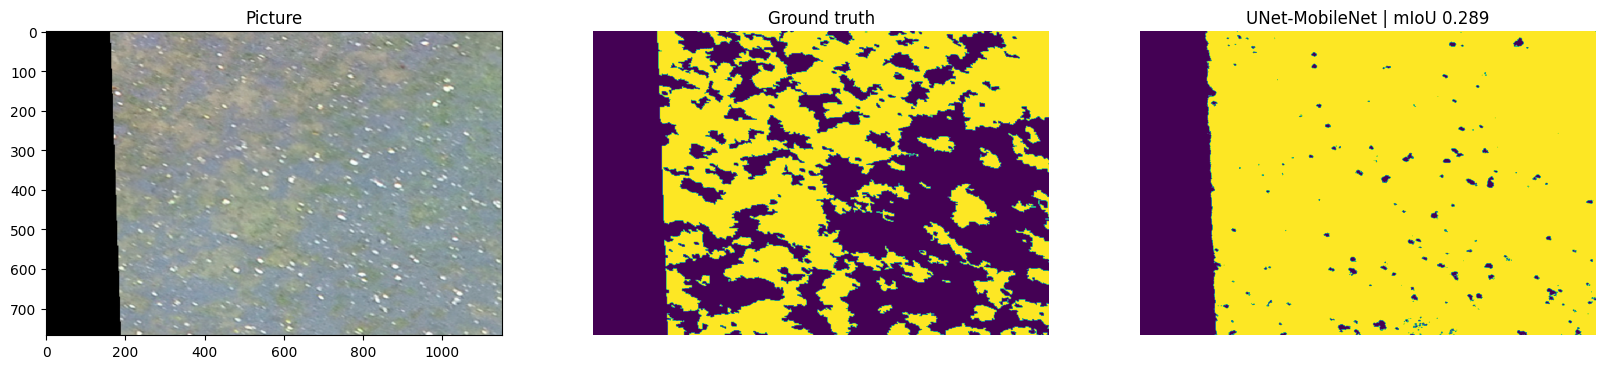

In [ ]:
image3, mask3 = test_set[33]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [ ]:
print('Test Set mIoU', np.mean(mob_miou))

Test Set mIoU 0.5285802173164839


In [ ]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set Pixel Accuracy 0.3393681978632744
